# Модель предсказаний оттока клиентов 

**Исходные данные:** 
исторические данные о поведении клиентов и расторжении договоров с банком


**Цель:**
спрогнозировать, уйдёт клиент из банка в ближайшее время или нет c предельно большим значением F1-меры (более 0.59)


**Этапы исследования:**


1.   Загрузка исходных данных и их общая оценка, построение гистрограмм для каждого столбца с числовыми значениями

2. Исследовать баланс классов, обучить модель без учёта дисбаланса

3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую

4. Провести финальное тестирование

5. Заключение


## 1 Загрузка исходных данных

In [1]:
!pip install imblearn
!pip install --upgrade matplotlib
!pip install -U scikit-learn

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, cross_val_predict,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import (f1_score, classification_report, 
                             confusion_matrix, accuracy_score, RocCurveDisplay,
                             roc_auc_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import (RandomOverSampler, SMOTE, SMOTENC, ADASYN, 
                                    BorderlineSMOTE, SVMSMOTE)
from imblearn.pipeline import Pipeline, make_pipeline

RANDOM_STATE = 42


<div class="alert alert-block alert-success">
</div>

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv("/content/drive/MyDrive/Yandex/Churn.csv")
except:
    df = pd.read_csv("/datasets/Churn.csv")

In [4]:
# function for primary analysis of data with non-normal distribution
# Kendall correlation
def df_info(df):
    # numeric and non-numeric for histograms and statistic info
    df_num = df.select_dtypes("number")
    df_no_num = df.select_dtypes(exclude="number")
    # correlation method for heatmap
    meth_corr = "kendall"
    # how to split the statistic info for numeric columns
    split_show = 8
    # display 2 digits after the decimal point
    pd.set_option('display.precision', 2)
    # change labels of columns
    df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower())
  
    # print('{:^24s}'.format("General information"))
    display(df.info(memory_usage="deep"))
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format(
        "Distribution of data in numeric columns"
        )
    )
    fig = plt.figure(figsize=(14,8))
    sfigs = fig.subfigures(round(len(df_num.columns)/4), 4)
    for i, axes in enumerate(sfigs.flat):
      try:
        axes.suptitle(df_num.columns[i])
        if len(df.iloc[:,i]) > 0:
          ax_1= axes.subplots(2, 1, sharex=True, 
                              gridspec_kw={"height_ratios": (.15, .85)})
          sns.boxplot(data=df, x=df_num.columns[i], orient="h", ax=ax_1[0])
          sns.histplot(data=df, x=df_num.columns[i], kde=True, ax=ax_1[1])
          plt.xlabel("")
          plt.ylabel("")
      except:
        break
    plt.show()
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format("Statistic information"))
    display(df_num.describe().iloc[:, :split_show])
    display(df_num.describe().iloc[:, split_show:])
    print()
    display(df_no_num.describe())
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format("Missing values"))
    miss_val = pd.DataFrame(df.isna().sum(), 
                            columns=["miss_count"])
    miss_val["miss_percent"] = round(miss_val/100, 2)
    miss_val["duplicates"] = df.duplicated().sum()
    display(miss_val.style.background_gradient("coolwarm", axis=0))
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format("Correlation"))
    plt.figure(figsize=(16,14))
    sns.heatmap(df.corr(method=meth_corr), annot=True, linewidths=0.3, 
                cmap='coolwarm', square=True)
    plt.show()
    pd.reset_option('display.precision')

In [5]:
# function for split data into 3 samples with stratify 
def train_valid_test(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    X_train, X_second, y_train, y_second = (
        train_test_split(X, y, test_size=0.6,
                         random_state=RANDOM_STATE,
                         stratify=y)
        )
    X_valid, X_test, y_valid, y_test = (
        train_test_split(X_second, y_second, test_size=0.5,
                         random_state=RANDOM_STATE,
                         stratify=y_second)
        )
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int16  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int8   
 4   tenure            10000 non-null  float32
 5   balance           10000 non-null  float32
 6   num_of_products   10000 non-null  int8   
 7   has_cr_card       10000 non-null  int8   
 8   is_active_member  10000 non-null  int8   
 9   estimated_salary  10000 non-null  float32
 10  exited            10000 non-null  int8   
dtypes: float32(3), int16(1), int8(5), object(2)
memory usage: 1.4 MB


None



   Distribution of data in numeric columns


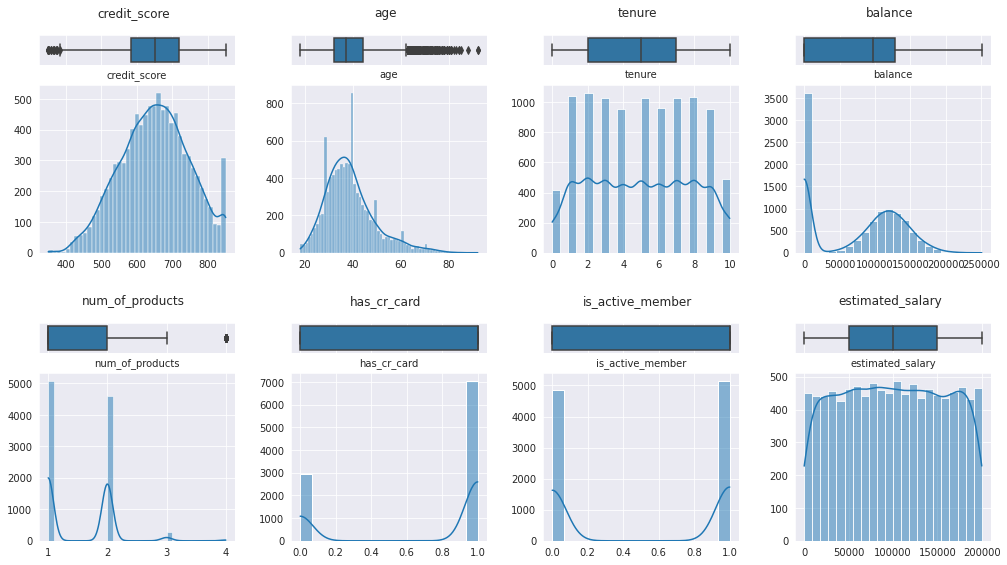



    Statistic information  


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,4.99,76485.89,1.53,0.71,0.52,100090.23
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48


,exited
count,10000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


,geography,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457




        Missing values     


,miss_count,miss_percent,duplicates
credit_score,0,0.00,0
geography,0,0.00,0
gender,0,0.00,0
age,0,0.00,0
tenure,0,0.00,0
balance,0,0.00,0
num_of_products,0,0.00,0
has_cr_card,0,0.00,0
is_active_member,0,0.00,0
estimated_salary,0,0.00,0




         Correlation       


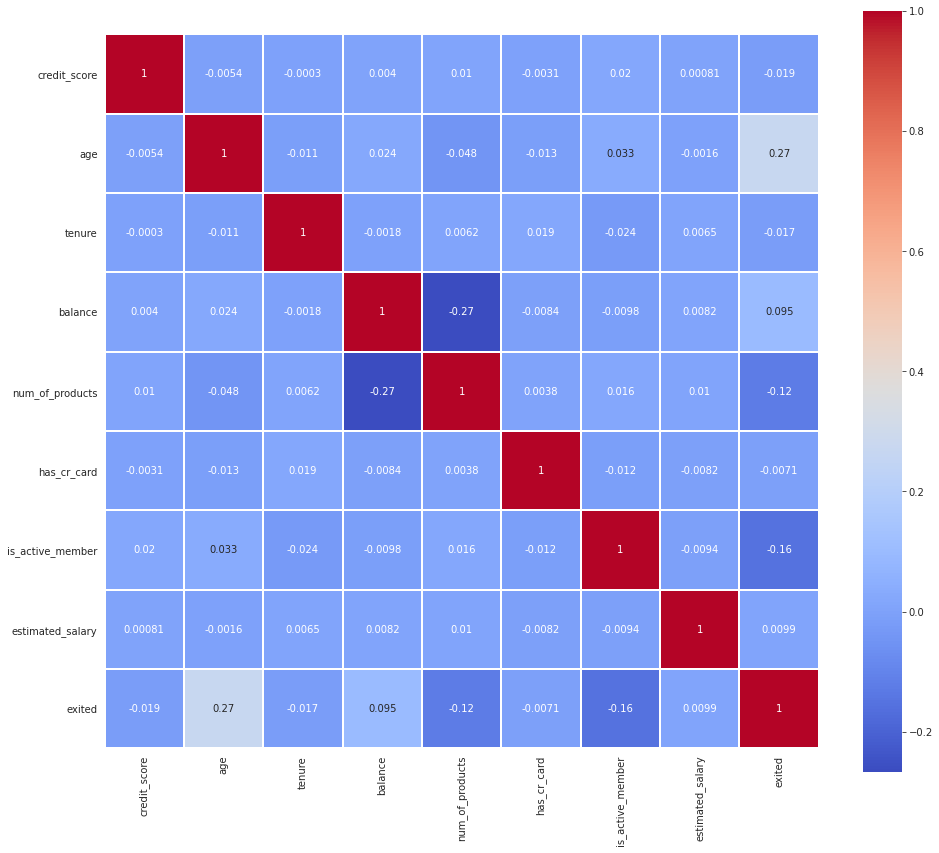

In [45]:
df_info(df)

### Вывод

Данные распределены не нормально, это следует учитывать при применении некоторых методов и функций. Целевой признак `excited` - бинарный, будущая модель будет решать задачу бинарной классификации. Для построения модели необходимо категориальные столбцы конвертировать с числовой тип и применить масштабирование для числовых столбцов. Так же отметим несбалансированность в бинарном столбце `has_cr_card`. В некоторых столбцах присутствуют всплески или аномальные значения и выбросы. В столбце `tenure` имеются пропущенные значения, которые требуется обработать. Явных дубликатов не обнаружено. Корреляция целевого признака с признаками - слабая или очень слабая. 

## 2 Подготовка данных

In [8]:
# check the unique ids
print(len(df))
df.customer_id.nunique()

10000


10000

In [9]:
# remove usless features
df.drop({"row_number", "customer_id", "surname"}, 
        axis=1, inplace=True)

In [10]:
# fill empty slots 
df.fillna(method="ffill", inplace=True)

0


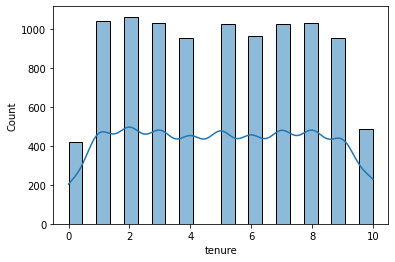

In [11]:
# check NaN-values and distribution 
print(df.tenure.isna().sum())
sns.histplot(df.tenure, kde=True)
plt.show()

In [12]:
# change types of numeric columns 
for name in df.select_dtypes("number").columns:
    if df[name].dtype == "int":
        df[name] = pd.to_numeric(df[name], downcast="integer")
    else:
        df[name] = pd.to_numeric(df[name], downcast="float")

In [13]:
# check the number of unqiue values without target
num_uniq = df.nunique()[:-1]
num_uniq

credit_score         460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
num_of_products        4
has_cr_card            2
is_active_member       2
estimated_salary    9999
dtype: int64

In [14]:
# remove the binary columns
num_uniq.drop(["has_cr_card","is_active_member"], inplace=True)

In [15]:
# for OneHotEncoder split data into 3 samples with helps special function
X_train, y_train, X_valid, y_valid, X_test, y_test = (
        train_valid_test(df, "exited"))
print([i.shape for i in [X_train, y_train, X_valid, y_valid, X_test, y_test]])

[(4000, 10), (4000,), (3000, 10), (3000,), (3000, 10), (3000,)]


In [16]:
# look at the dataset
X_train.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
829,577,France,Female,39,10.0,0.000000,2,1,0,10553.309570
5937,740,Spain,Female,31,8.0,0.000000,2,0,0,86657.476562
4905,590,Spain,Male,30,7.0,0.000000,2,1,0,83090.351562
9413,751,France,Female,44,10.0,0.000000,2,1,0,170634.484375
4953,629,Spain,Male,34,1.0,121151.046875,1,0,0,119357.929688


In [17]:
# merge OHE-method and scaler 
ohe_scale = make_column_transformer(
    (OneHotEncoder(drop="first", dtype="int8", sparse_output=False), 
    num_uniq[num_uniq < 12].index),
    (RobustScaler(), num_uniq[(num_uniq > 12)].index),
    remainder="passthrough",
    verbose_feature_names_out=False
)
# output is dataframe
ohe_scale.set_output(transform="pandas")
# apply method
X_train = ohe_scale.fit_transform(X_train)

In [18]:
# look at fist fove rows
X_train.head(3)

,geography_Germany,geography_Spain,gender_Male,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,...,tenure_10.0,num_of_products_2,num_of_products_3,num_of_products_4,credit_score,age,balance,estimated_salary,has_cr_card,is_active_member
829,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,-0.567669,0.166667,-0.753689,-0.910129,1,0
5937,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0.657895,-0.500000,-0.753689,-0.132279,0,0
4905,0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,-0.469925,-0.583333,-0.753689,-0.168738,1,0


### Вывод
Столбцы surname, `row_num`, `customer_id` и `surname` были удалены как бесполезные признаки для будущей модели. Пропущенные значения были заполнены по принципу использования предыдущего значения для сохранения формы распределения. Изменены типы значений столбцов. Датасет разделен на три части: тренировочную, валидационную и тестовую. Для тестовой выборки проведены масштабирование и перевод значений в бинарный тип.

## 3 Баланс классов

In [19]:
# create a new dataframe with binary columns
binary = X_train.loc[:, X_train.isin([0,1]).all()]

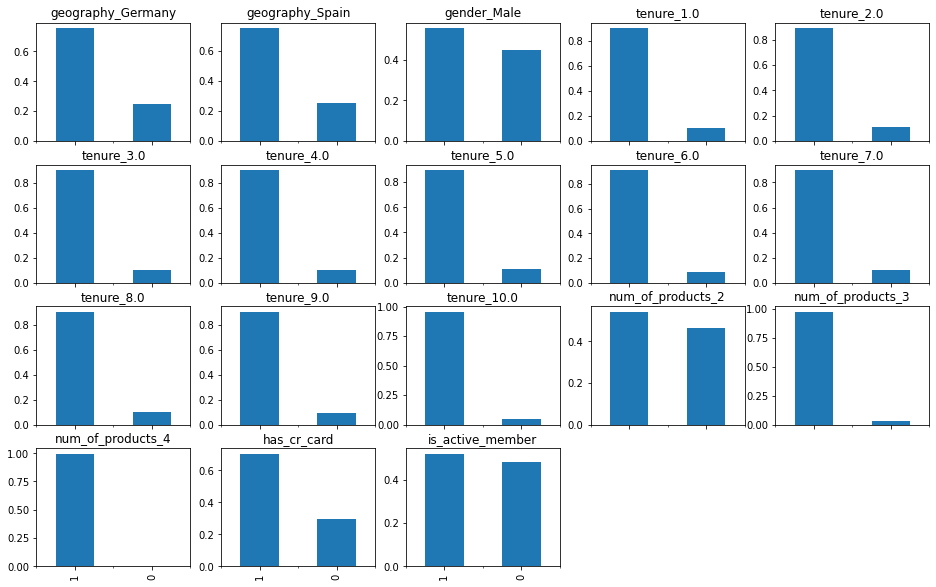

In [20]:
# show distribution of value in binary columns
fig, axs = plt.subplots(round(len(binary.columns)/5), 5, figsize=(16, 10), 
                        sharex=True)
for i, ax in enumerate(axs.flat):
    try:
        binary.iloc[:, i].value_counts(normalize=True).plot(kind="bar", ax=ax)
        ax.set_title(binary.iloc[:, i].name)
    except:
        ax.set_axis_off()
plt.show()

In [21]:
# show share of units
binary.mean().to_frame().style.background_gradient("coolwarm")

,0
geography_Germany,0.246750
geography_Spain,0.251250
gender_Male,0.552500
tenure_1.0,0.103750
tenure_2.0,0.111250
tenure_3.0,0.101500
tenure_4.0,0.100500
tenure_5.0,0.106250
tenure_6.0,0.088500
tenure_7.0,0.102500


In [22]:
# model's score with imbalanced data
baseline = RandomForestClassifier(random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
prediction = baseline.predict(ohe_scale.transform(X_valid))
print(f"Accuracy: {accuracy_score(y_valid, prediction):.2}")
print(f"ROC-AUC: {roc_auc_score(y_valid, baseline.predict_proba(ohe_scale.transform(X_valid))[:, 1]):.2}")
print("Confusion matrix:\n", confusion_matrix(y_valid, prediction))
print("Classification report:\n", classification_report(y_valid, prediction))

Accuracy: 0.86
ROC-AUC: 0.85
Confusion matrix:
 [[2307   82]
 [ 335  276]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.77      0.45      0.57       611

    accuracy                           0.86      3000
   macro avg       0.82      0.71      0.74      3000
weighted avg       0.85      0.86      0.85      3000



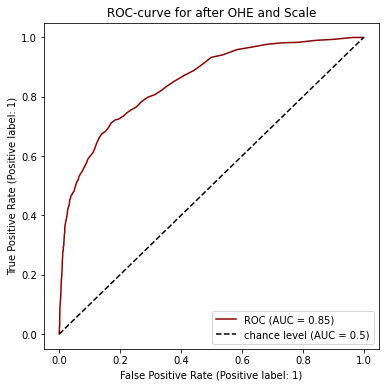

In [23]:
fig, axs = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_estimator(
    baseline, ohe_scale.transform(X_valid), y_valid,
    name="ROC", color="darkred",ax=axs
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("ROC-curve for after OHE and Scale")
plt.legend()
plt.show()

In [24]:
# create a list for different upsampling methods 
over_sample = [RandomOverSampler(random_state=RANDOM_STATE), 
            SMOTE(random_state=RANDOM_STATE), 
            SMOTENC(random_state=RANDOM_STATE, 
                    categorical_features=X_train.columns\
                    .get_indexer(binary.columns)),
            ADASYN(random_state=RANDOM_STATE), 
            BorderlineSMOTE(random_state=RANDOM_STATE), 
            SVMSMOTE(random_state=RANDOM_STATE)
]

In [25]:
# make cross-validation
cross_v = StratifiedKFold(n_splits=10, shuffle=False)

In [26]:
# choose the best method for oversampling
result_ovs = []
roc_ovs = []
for myth in over_sample:
    pip_ovs = make_pipeline(myth, 
                           RandomForestClassifier(random_state=RANDOM_STATE))
    score_ovs = cross_val_score(pip_ovs, X_train, y_train, scoring="f1", 
                               cv=cross_v)
    y_pred_proba = cross_val_predict(pip_ovs, X_train, y_train, 
                                     cv=cross_v, method="predict_proba")
    # predicted probabilities of positive class
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_ovs.append((fpr, tpr, roc_auc))
    result_ovs.append(score_ovs)
    print(f'{str(myth).split("(")[0]} =\
    {score_ovs.mean():.2}')

RandomOverSampler =    0.58
SMOTE =    0.57
SMOTENC =    0.56
ADASYN =    0.57
BorderlineSMOTE =    0.57
SVMSMOTE =    0.58


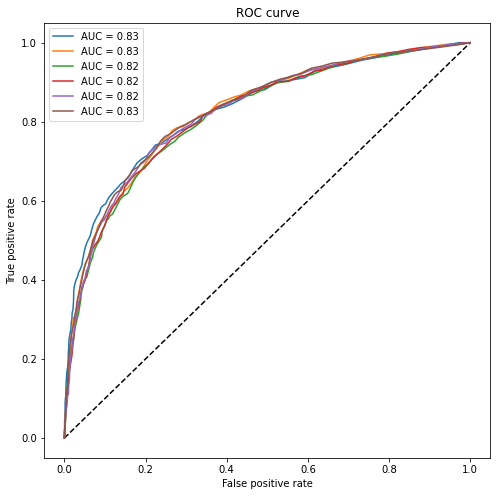

In [27]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
for fpr, tpr, roc_auc in roc_ovs:
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

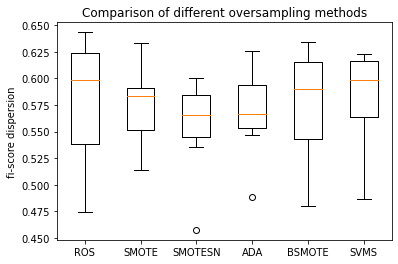

In [28]:
# show spreading f1-score 
plt.boxplot(result_ovs, 
            labels=["ROS", "SMOTE", "SMOTESN", "ADA", "BSMOTE", "SVMS"])
plt.title("Comparison of different oversampling methods")
plt.ylabel("fi-score dispersion")
plt.show()

### Вывод

Ввиду малого наличия в данных класса единиц - метрики качества получаются смещенными. Для рассмотрения метрик был использован алгоритм `RandomForestClassifier`. Высокая точность(`accuracy`) обусловлена высокой вероятностью предсказания класса 0, так же видим большое количество ошибок в предсказания обученной модели(сумма вне главной диагонали матрицы ошибок). Все это подводит к использованию перебалансировки классов путем добавления строк с недостающим признаком. Предварительно разделив данные на стратифицированные выборки, чтобы избежать переобучения модели, был выбран метод `SVMSMOTE` со наибольшим средним значеним `f1-score`, исходя из графиков распределения значений. Оперировать конкретными значениями, учитывая их стохастический характер, нет возможности.

## 4 Лучшая модель

In [29]:
# create a list with the diffrent algorithms 
algorithm = [LogisticRegression(random_state=RANDOM_STATE), 
             DecisionTreeClassifier(random_state=RANDOM_STATE), 
             KNeighborsClassifier(), 
             RandomForestClassifier(random_state=RANDOM_STATE),
             SVC(gamma='auto')]

In [30]:
start_time = time.time()
# choose the best algorithm 
result_alg = []
for alg in algorithm:
    pip_alg = make_pipeline(BorderlineSMOTE(random_state=RANDOM_STATE),
                            alg)
    score_alg = cross_val_score(pip_alg, X_train, y_train, 
                                scoring="f1", cv=cross_v)
    result_alg.append(score_alg)
    print(f'{str(alg).replace("()", "")} = {score_alg.mean():.2}' ) 
print("--- %s seconds ---" % (time.time() - start_time))

LogisticRegression(random_state=42) = 0.54
DecisionTreeClassifier(random_state=42) = 0.46
KNeighborsClassifier = 0.5
RandomForestClassifier(random_state=42) = 0.57
SVC(gamma='auto') = 0.56
--- 19.76004385948181 seconds ---


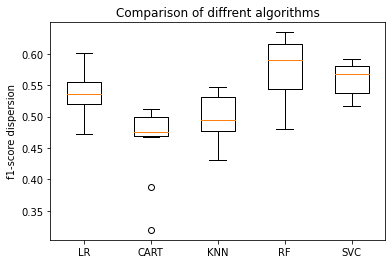

In [31]:
# show the spreding result 
plt.boxplot(result_alg, labels=["LR", "CART", "KNN", "RF", "SVC"])
plt.title("Comparison of diffrent algorithms")
plt.ylabel("f1-score dispersion")
plt.show()

In [32]:
# create a dictionary for different parameters 
params = {
    'rf__n_estimators': range(10, 70, 10),
    'rf__criterion': ["gini", "entropy", "log_loss"],
    'rf__max_depth': range(2, 25, 1)
    }

In [33]:
start_time = time.time()
# make pipeline for sampling and algorithm
pipeline = Pipeline([("sampling", BorderlineSMOTE(random_state=RANDOM_STATE)),
                     ("rf", RandomForestClassifier(n_estimators=100, 
                                                  random_state=RANDOM_STATE))])
# use GridSearch for search the best parameters
grid_search = GridSearchCV(pipeline, param_grid=params, cv=cross_v, 
                        scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 986.1854763031006 seconds ---


In [34]:
start_time = time.time()
# try another search for getting better parameters
random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                   cv=cross_v, scoring='f1', 
                                   return_train_score=True)
random_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.272196292877197 seconds ---


In [35]:
# show the best f1-score for GridSearc model
grid_search.best_score_

0.5870102238482776

In [36]:
# show the best f1-score for RandomizedSearch model
random_search.best_score_

0.5870102238482776

In [37]:
# function to print the dependence of the score on the hyperparameters
def graph_quality(search_method):
    quality = pd.DataFrame(search_method.cv_results_)

    quality.drop(quality.columns.difference(["mean_train_score", 
                                              "param_rf__n_estimators", 
                                              "param_rf__max_depth", 
                                              "param_rf__criterion"]), axis=1, 
                inplace=True)
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.lineplot(data=quality, x="param_rf__max_depth", y="mean_train_score", 
                hue="param_rf__criterion", markers=True, estimator=None, 
                style="param_rf__criterion",ax=ax[0])
    sns.lineplot(data=quality, x="param_rf__n_estimators", y="mean_train_score", 
                hue="param_rf__criterion", markers=True, estimator=None, 
                style="param_rf__criterion",ax=ax[1])
    plt.show()

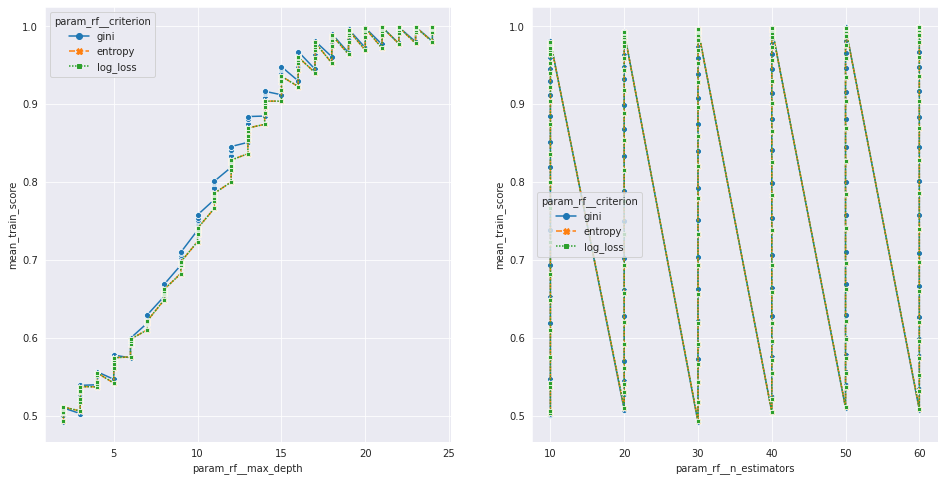

In [38]:
# show the ghaph for GridSearch
graph_quality(grid_search)

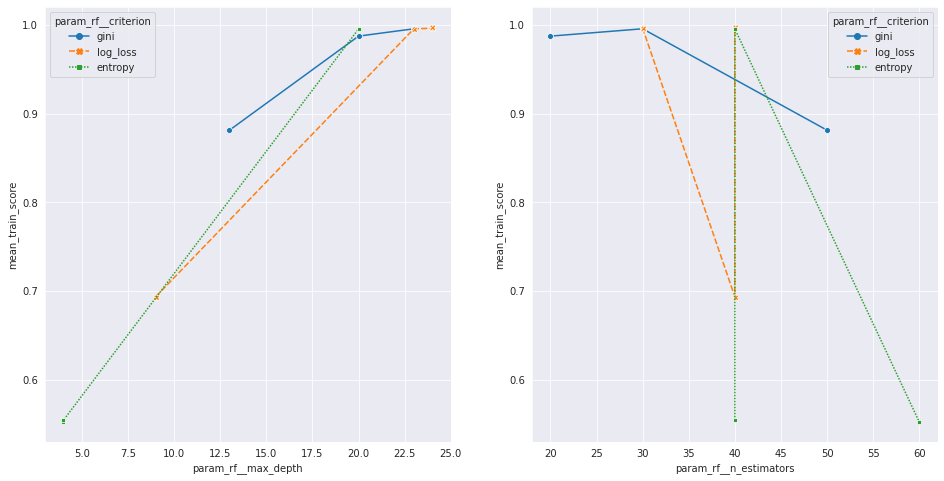

In [39]:
# show the ghaph for RandomizedSeach
graph_quality(random_search)

### Вывод
Среди нескольких выбранных алгоритмов для задач бинарной классификации наиболее качественным оказался `RandomForestClassifier`. Для этого алгорита подбирались параметры с использованием нескольких методов. Качество, определенной с помощью метрики `f1-score`, на обученной выборке показало значение около 0.59

## 5 Финальное тестирование

In [40]:
# calculate predictions on the transforming test sample
grid_predict = grid_search.predict(ohe_scale.transform(X_test))
random_predict = random_search.predict(ohe_scale.transform(X_test))

In [42]:
# metrics for the prediction GridSearch
print(f'f1 score for GridSearchCV = {f1_score(y_test, grid_predict):.3f}')
print(f'Accuracy for GridSearchCV = {accuracy_score(y_test, grid_predict):.3f}')
print(f"ROC-AUC = {roc_auc_score(y_valid, grid_search.predict_proba(ohe_scale.transform(X_test))[:, 1]):.3f}")
print(classification_report(y_test, grid_predict))

f1 score for GridSearchCV = 0.594
Accuracy for GridSearchCV = 0.822
ROC-AUC = 0.518
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2389
           1       0.55      0.64      0.59       611

    accuracy                           0.82      3000
   macro avg       0.73      0.75      0.74      3000
weighted avg       0.83      0.82      0.83      3000



In [43]:
# metrics for the prediction RandomizedSearch
print(f'f1 score for RandomizedSearchCV = {f1_score(y_test, random_predict):.3f}')
print(f'Accuracy for RandomizedSearchCV = {accuracy_score(y_test, random_predict):.3f}')
print(f"ROC-AUC = {roc_auc_score(y_valid, grid_search.predict_proba(ohe_scale.transform(X_test))[:, 1]):.3f}")
print(classification_report(y_test, random_predict))

f1 score for RandomizedSearchCV = 0.594
Accuracy for RandomizedSearchCV = 0.822
ROC-AUC = 0.518
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2389
           1       0.55      0.64      0.59       611

    accuracy                           0.82      3000
   macro avg       0.73      0.75      0.74      3000
weighted avg       0.83      0.82      0.83      3000



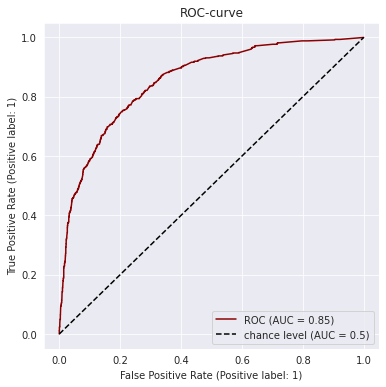

In [44]:
fig, axs = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(y_test,
    grid_search.predict_proba(ohe_scale.transform(X_test))[:, 1], 
    name="ROC", color="darkred",ax=axs
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("ROC-curve")
plt.legend()
plt.show()

### Вывод
Для предсказаний использовалось две модели, для которых параметры подбирались различными методами. Метрика качества показала довольно высокие значения для класса 1, более 0.6, наряду с высокой точностью. Метрики минорного класса возросли. Суммарная метрика `f1` показывает значение более 0.7

## 5 Заключение

Для исходного датасета была проведена скурпулезная работа по предварительной обработке данных, которая включила в себя: первичный анализ, заполнение пропусков, изменение типов данных. Стоит отдельно отметить подготовку данных для последующей их обработки моделью. Для этого некоторых столбцы были удалены, другие переведены в бинарный класс. Для остальных числовых столбцов проведено масштабирование значение для приведения их к единому виду. Ввиду того, что при первичном анализе были замечены аномалии и выбросы в данных, особенно тщательно подбирался метод масштабирования. После масштибрования наблюдался дисбаланс в классах, что было устранено подбором и применением методики, позволяющей добавить значения в минорный класс. Для стоящей задачи бинарной классификации была подобрана соответствующая модель и параметры для нее. Качество обученой модели - удовлетворительное. Метрика качества показала значение более 0.6, что позволяет определять потенциально уходящих клиентов с вероятностью более 60% 